**Declare packages:**

In [66]:
import warnings

warnings.filterwarnings("ignore")

## Data
import pandas as pd
import numpy as np

## Plots
import matplotlib.pyplot as plt
import seaborn as sns

## Machine learning
from sklearn import metrics, preprocessing

## Deep learning
from keras import models, layers, utils

**Import WikiArt dataset:**

In [67]:
# WikiArt
wiki_art_set = pd.read_csv("datasets/wiki_art.csv")

wiki_art_set = wiki_art_set[~wiki_art_set["class_name"].isna()]
wiki_art_set["art_id"] = range(0, len(wiki_art_set))
wiki_art_set["genre"] = wiki_art_set["class_name"]
wiki_art_set = wiki_art_set.drop(["class_name", "labels"], axis='columns')

wiki_art_set

,image_path,art_id,genre
0,/kaggle/input/wikiart-gangogh-creating-art-gan...,0,genre-painting
1,/kaggle/input/wikiart-gangogh-creating-art-gan...,1,genre-painting
2,/kaggle/input/wikiart-gangogh-creating-art-gan...,2,genre-painting
3,/kaggle/input/wikiart-gangogh-creating-art-gan...,3,genre-painting
4,/kaggle/input/wikiart-gangogh-creating-art-gan...,4,genre-painting
...,...,...,...
96009,/kaggle/input/wikiart-gangogh-creating-art-gan...,96009,landscape
96010,/kaggle/input/wikiart-gangogh-creating-art-gan...,96010,landscape
96011,/kaggle/input/wikiart-gangogh-creating-art-gan...,96011,landscape
96012,/kaggle/input/wikiart-gangogh-creating-art-gan...,96012,landscape


**Import Users dataset:**

In [68]:
# Users
users_set = pd.read_csv("datasets/users.csv")

users_set["genres"] = users_set.apply(lambda row: set([row["genre_1"], row["genre_2"], row["genre_3"]]), axis=1)
users_set["user_id"] = range(0, len(users_set))
users_set = users_set.drop(["id", "genre_1", "genre_2", "genre_3"], axis='columns')

users_set

,first_name,last_name,gender,favorite_color_hex,age,genres,user_id
0,Inglebert,McKerton,Male,#6d2c6f,16,"{landscape, animal-painting, still-life}",0
1,Spike,Hanhardt,Male,#d49fd1,53,"{cityscape, landscape, abstract}",1
2,Muhammad,Hasely,Male,#f6de77,60,"{portrait, mythological-painting, nude-paintin...",2
3,Kaleb,Verring,Male,#db2552,50,"{mythological-painting, abstract, still-life}",3
4,Donovan,Dethloff,Genderqueer,#d14bad,38,"{mythological-painting, landscape}",4
...,...,...,...,...,...,...,...
995,Del,Bycraft,Male,#988aaa,54,"{marina, animal-painting}",995
996,Ofilia,Hasted,Female,#8edfc5,32,"{figurative, landscape, abstract}",996
997,Haley,People,Female,#a5c0fa,54,"{nude-painting-nu, abstract}",997
998,Charlena,Lipprose,Female,#4d5f42,34,"{landscape, symbolic-painting, still-life}",998


**Rating dataset:**

In [69]:
ratings_set = pd.read_csv("datasets/ratings.csv")

ratings_set = ratings_set.merge(wiki_art_set[["art_id", "image_path"]], how="left")
ratings_set = ratings_set.rename(columns={"explicit_rating": "y"})

ratings_set

,user_id,art_id,y,watched_to_the_end,liked,image_path
0,1,41354,6.0,True,True,/kaggle/input/wikiart-gangogh-creating-art-gan...
1,1,1395,6.0,True,True,/kaggle/input/wikiart-gangogh-creating-art-gan...
2,1,86062,5.0,True,True,/kaggle/input/wikiart-gangogh-creating-art-gan...
3,1,32920,6.0,True,True,/kaggle/input/wikiart-gangogh-creating-art-gan...
4,1,8807,6.0,True,True,/kaggle/input/wikiart-gangogh-creating-art-gan...
...,...,...,...,...,...,...
14491,1000,41518,7.0,False,True,/kaggle/input/wikiart-gangogh-creating-art-gan...
14492,1000,46329,5.0,False,False,/kaggle/input/wikiart-gangogh-creating-art-gan...
14493,1000,94235,9.0,False,True,/kaggle/input/wikiart-gangogh-creating-art-gan...
14494,1000,60828,7.0,False,True,/kaggle/input/wikiart-gangogh-creating-art-gan...


**Extract context:**

In [70]:
context_set = ratings_set[["user_id", "art_id", "y", "watched_to_the_end", "liked"]]

context_set.head()

,user_id,art_id,y,watched_to_the_end,liked
0,1,41354,6.0,True,True
1,1,1395,6.0,True,True
2,1,86062,5.0,True,True
3,1,32920,6.0,True,True
4,1,8807,6.0,True,True


**Analyzing data:**

In [71]:
tags = wiki_art_set["genre"].unique()

print(tags)

['genre-painting' 'symbolic-painting' 'nude-painting-nu' 'flower-painting'
 'animal-painting' 'religious-painting' 'figurative' 'marina' 'abstract'
 'still-life' 'portrait' 'cityscape' 'mythological-painting' 'landscape']


In [72]:
for tag in tags:
    wiki_art_set[tag] = wiki_art_set["genre"].apply(lambda x: 1 if tag in x else 0)
wiki_art_set.head()

,image_path,art_id,genre,genre-painting,symbolic-painting,nude-painting-nu,flower-painting,animal-painting,religious-painting,figurative,marina,abstract,still-life,portrait,cityscape,mythological-painting,landscape
0,/kaggle/input/wikiart-gangogh-creating-art-gan...,0,genre-painting,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,/kaggle/input/wikiart-gangogh-creating-art-gan...,1,genre-painting,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,/kaggle/input/wikiart-gangogh-creating-art-gan...,2,genre-painting,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,/kaggle/input/wikiart-gangogh-creating-art-gan...,3,genre-painting,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,/kaggle/input/wikiart-gangogh-creating-art-gan...,4,genre-painting,1,0,0,0,0,0,0,0,0,0,0,0,0,0


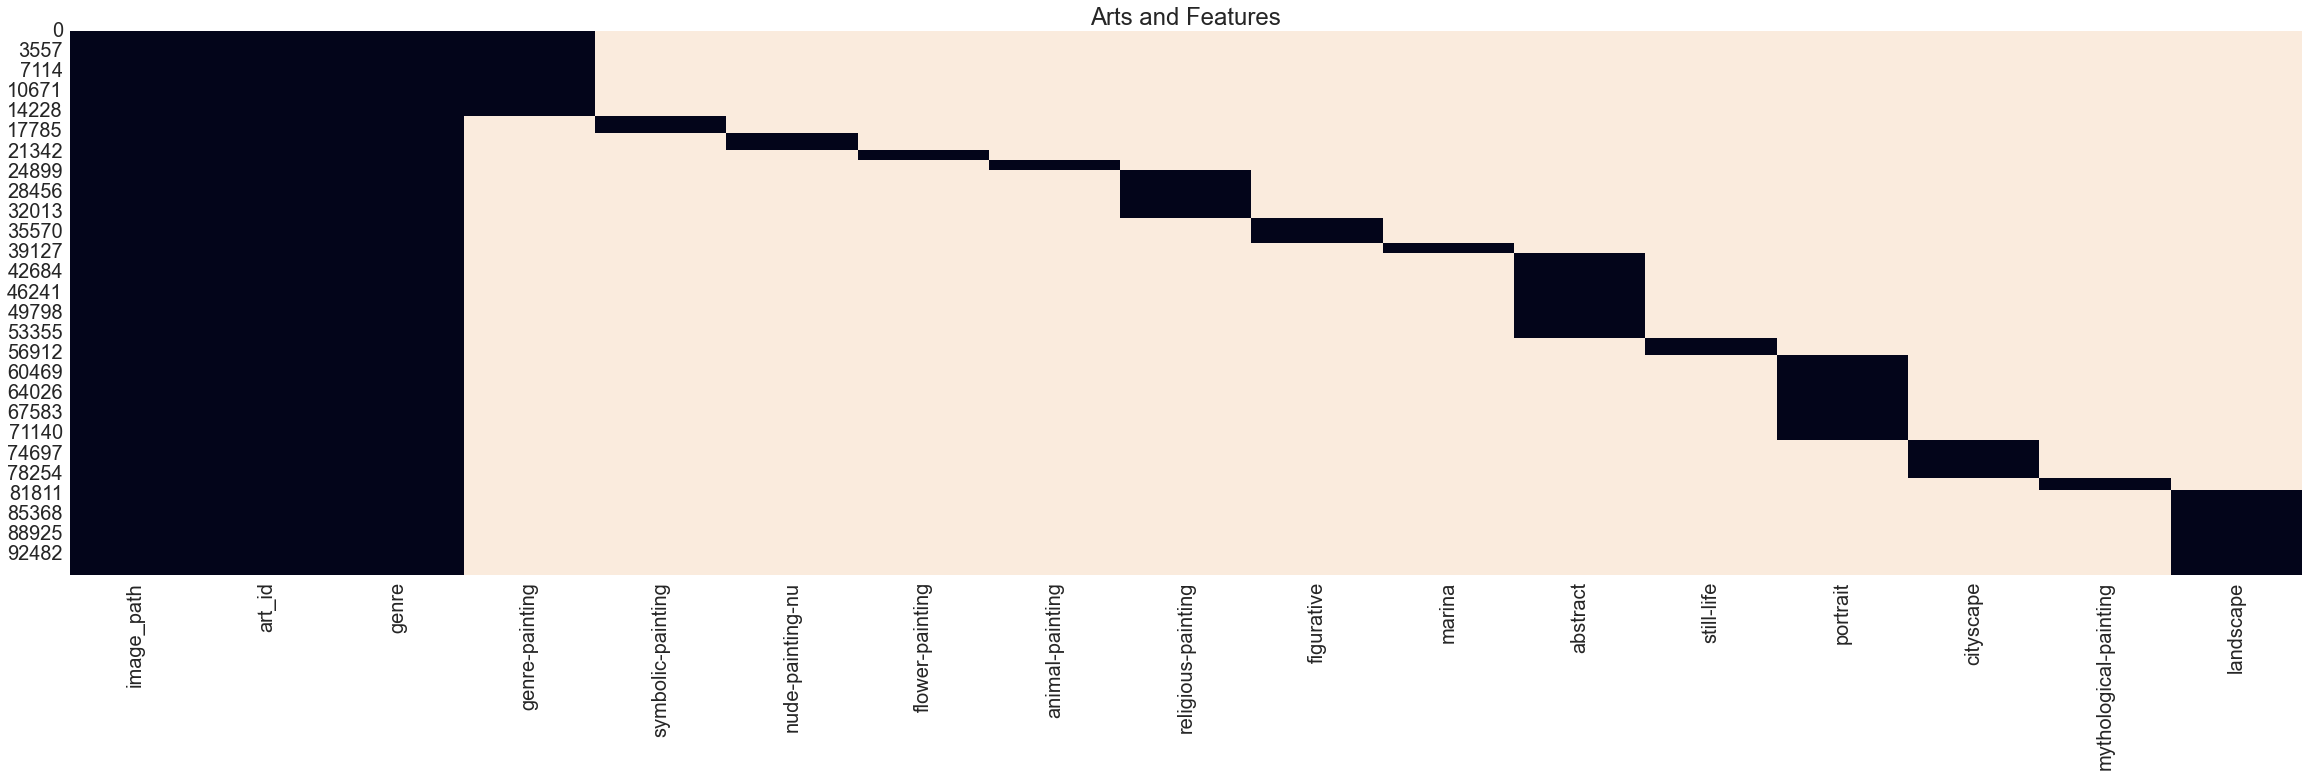

In [73]:
plt.rc('font', size=20)

fig, ax = plt.subplots(figsize=(40, 10))

sns.heatmap(wiki_art_set == 0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Arts and Features")

plt.show()

**Users and ratings:**

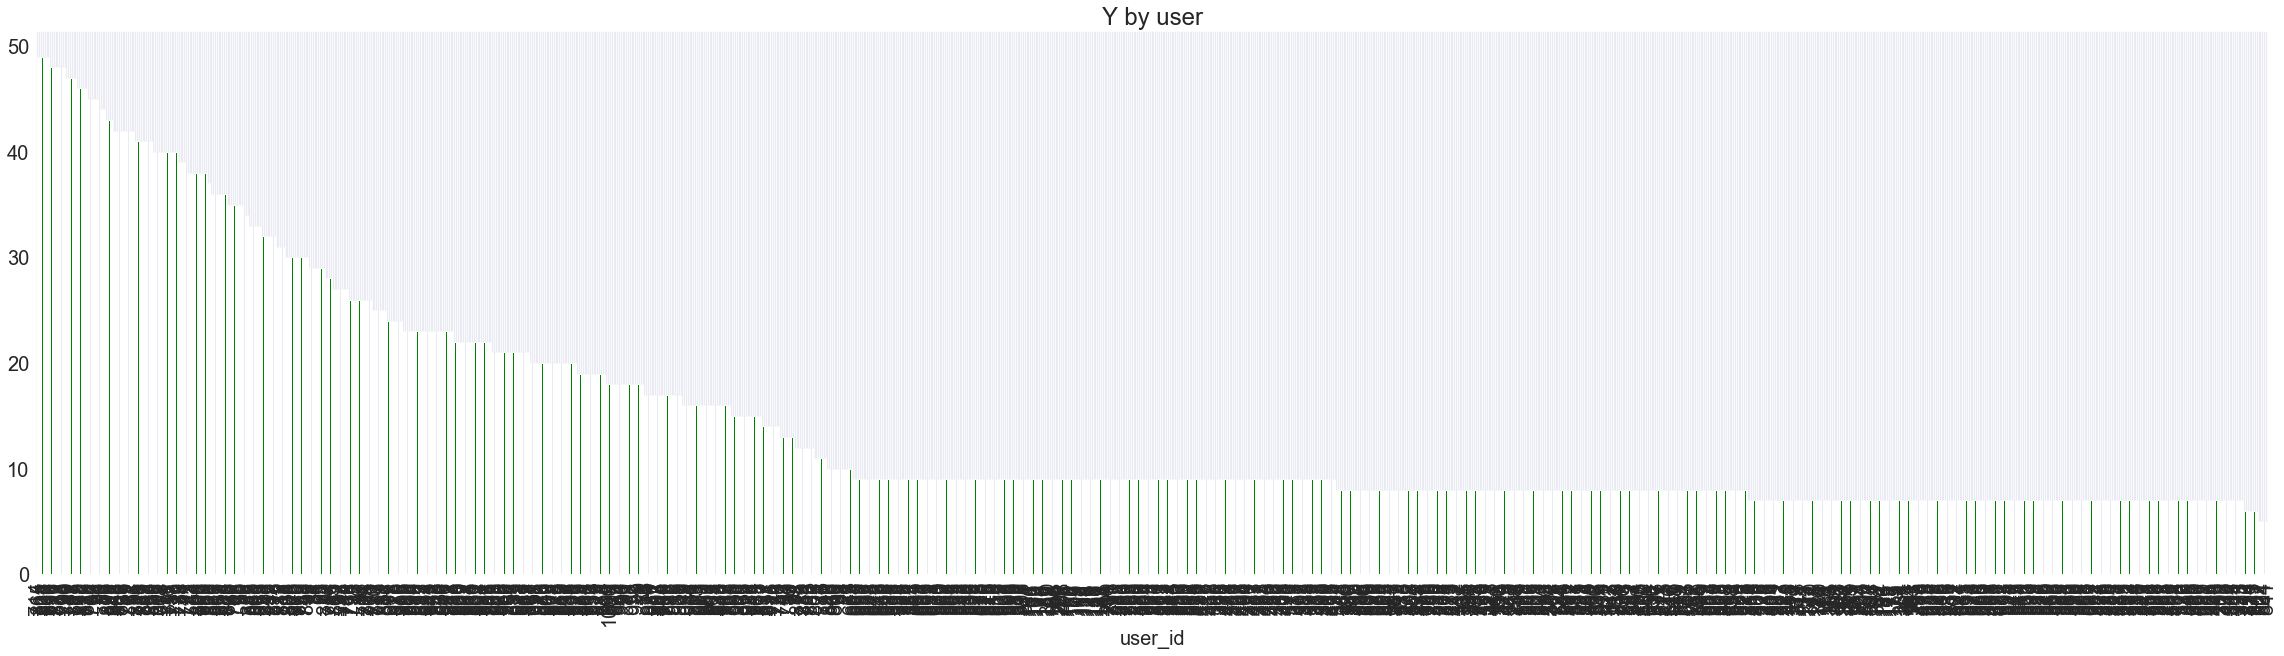

In [74]:
ratings_set.groupby("user_id").count()["art_id"].sort_values(ascending=False).plot(
    kind="bar", color="green", title="Y by user", figsize=(40, 10)).grid(axis='y')

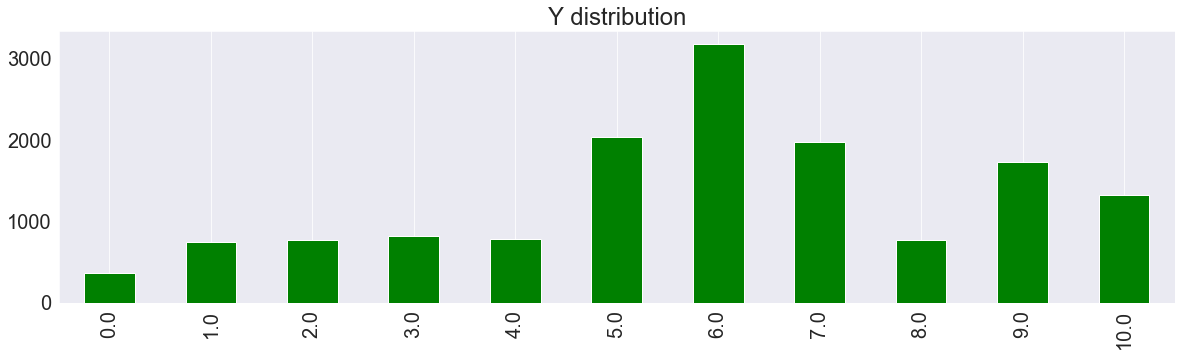

In [75]:
ratings_set["y"].value_counts().sort_index().plot(kind="bar", color="green", title="Y distribution",
                                                  figsize=(20, 5)).grid(axis='y')
plt.show()

In [76]:
tmp = ratings_set.copy()

ratings_set = tmp.pivot_table(index="user_id", columns="art_id", values="y")

missing_columns = list(set(wiki_art_set.index) - set(ratings_set.columns))

for column in missing_columns:
    ratings_set[column] = np.nan
ratings_set = ratings_set[sorted(ratings_set.columns)]

ratings_set

art_id,0,1,2,3,4,5,6,7,8,9,...,96004,96005,96006,96007,96008,96009,96010,96011,96012,96013
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


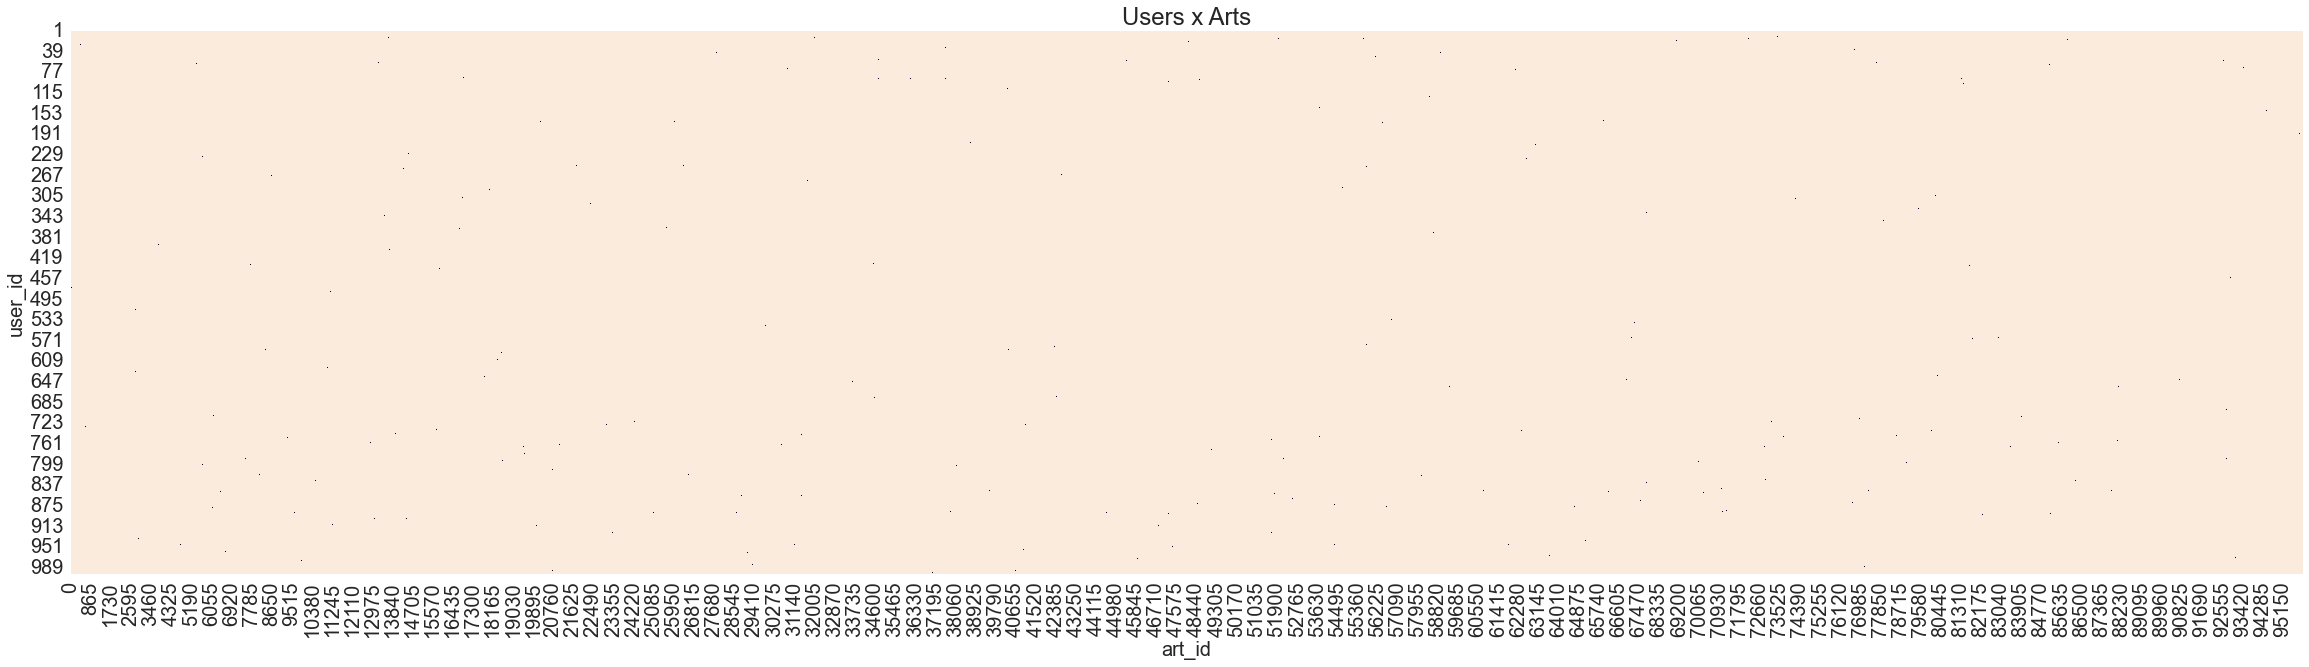

In [77]:
fig, ax = plt.subplots(figsize=(40, 10))
sns.heatmap(ratings_set.isnull(), vmin=0, vmax=1, cbar=False, ax=ax).set_title("Users x Arts")
plt.show()

**Context:**

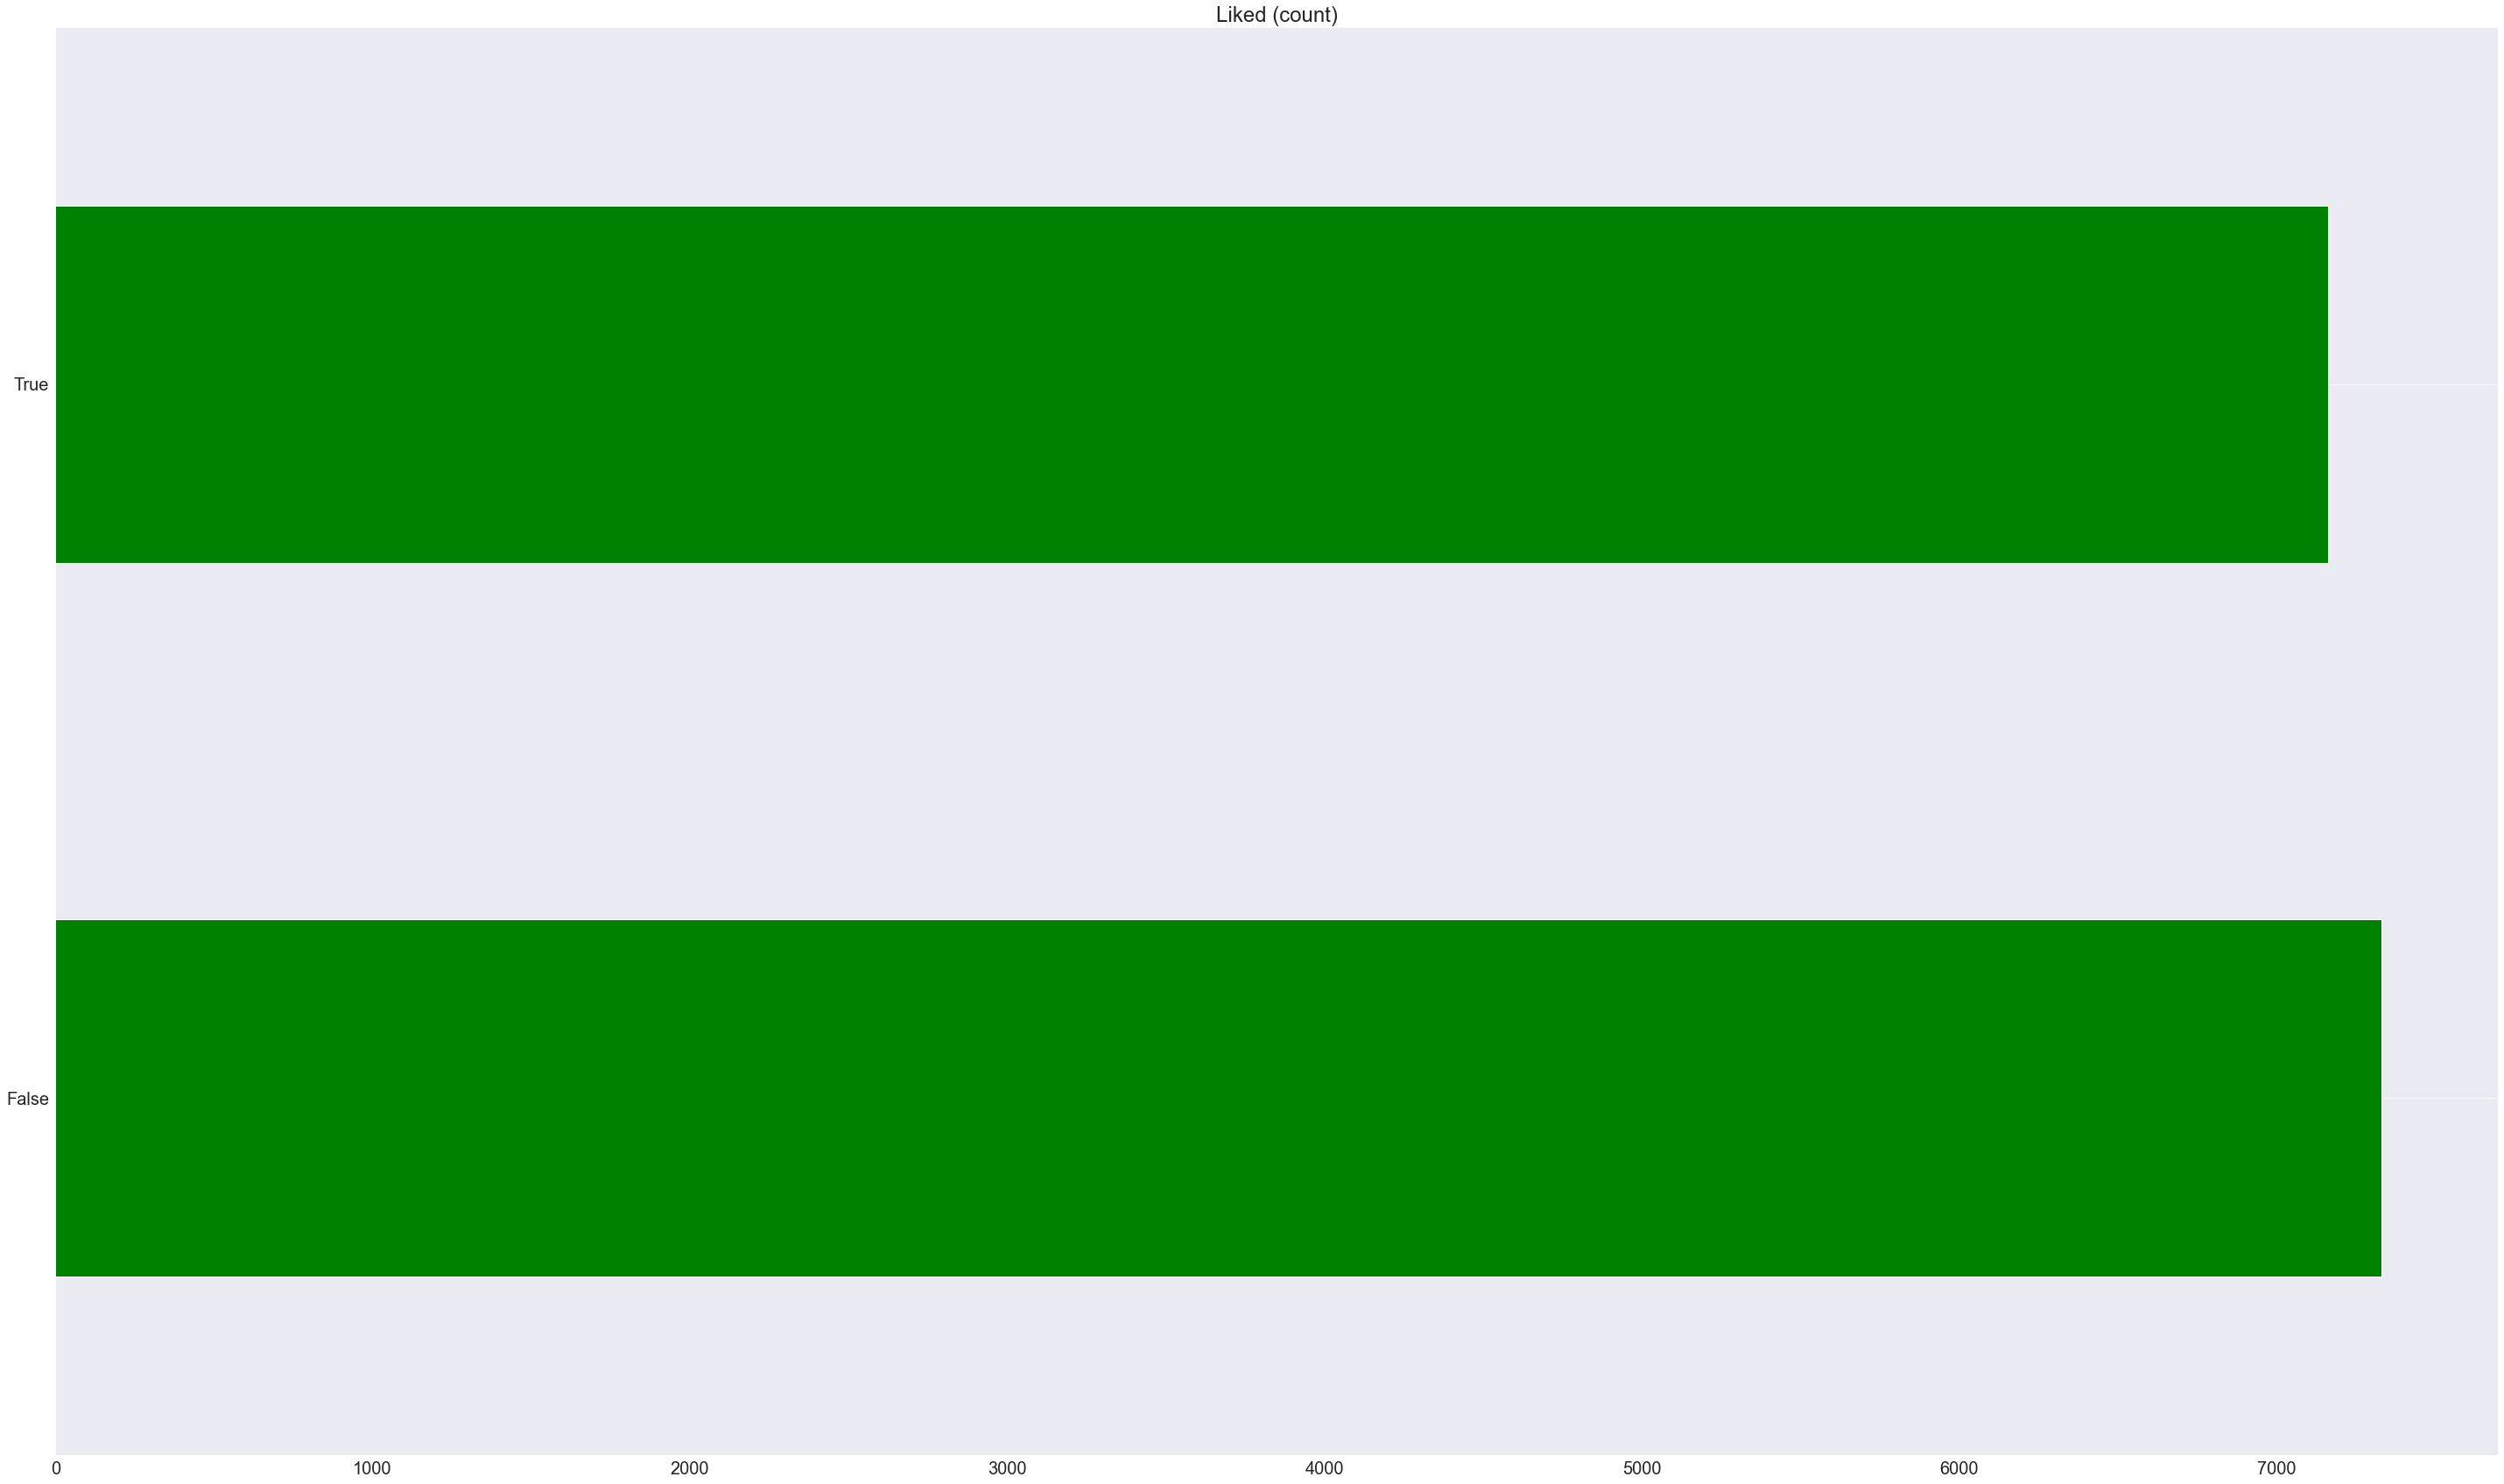

In [78]:
context_set["liked"].value_counts().plot(kind="barh", color="green", title="Liked (count)",
                                         figsize=(50, 30)).grid(axis='x')
plt.show()

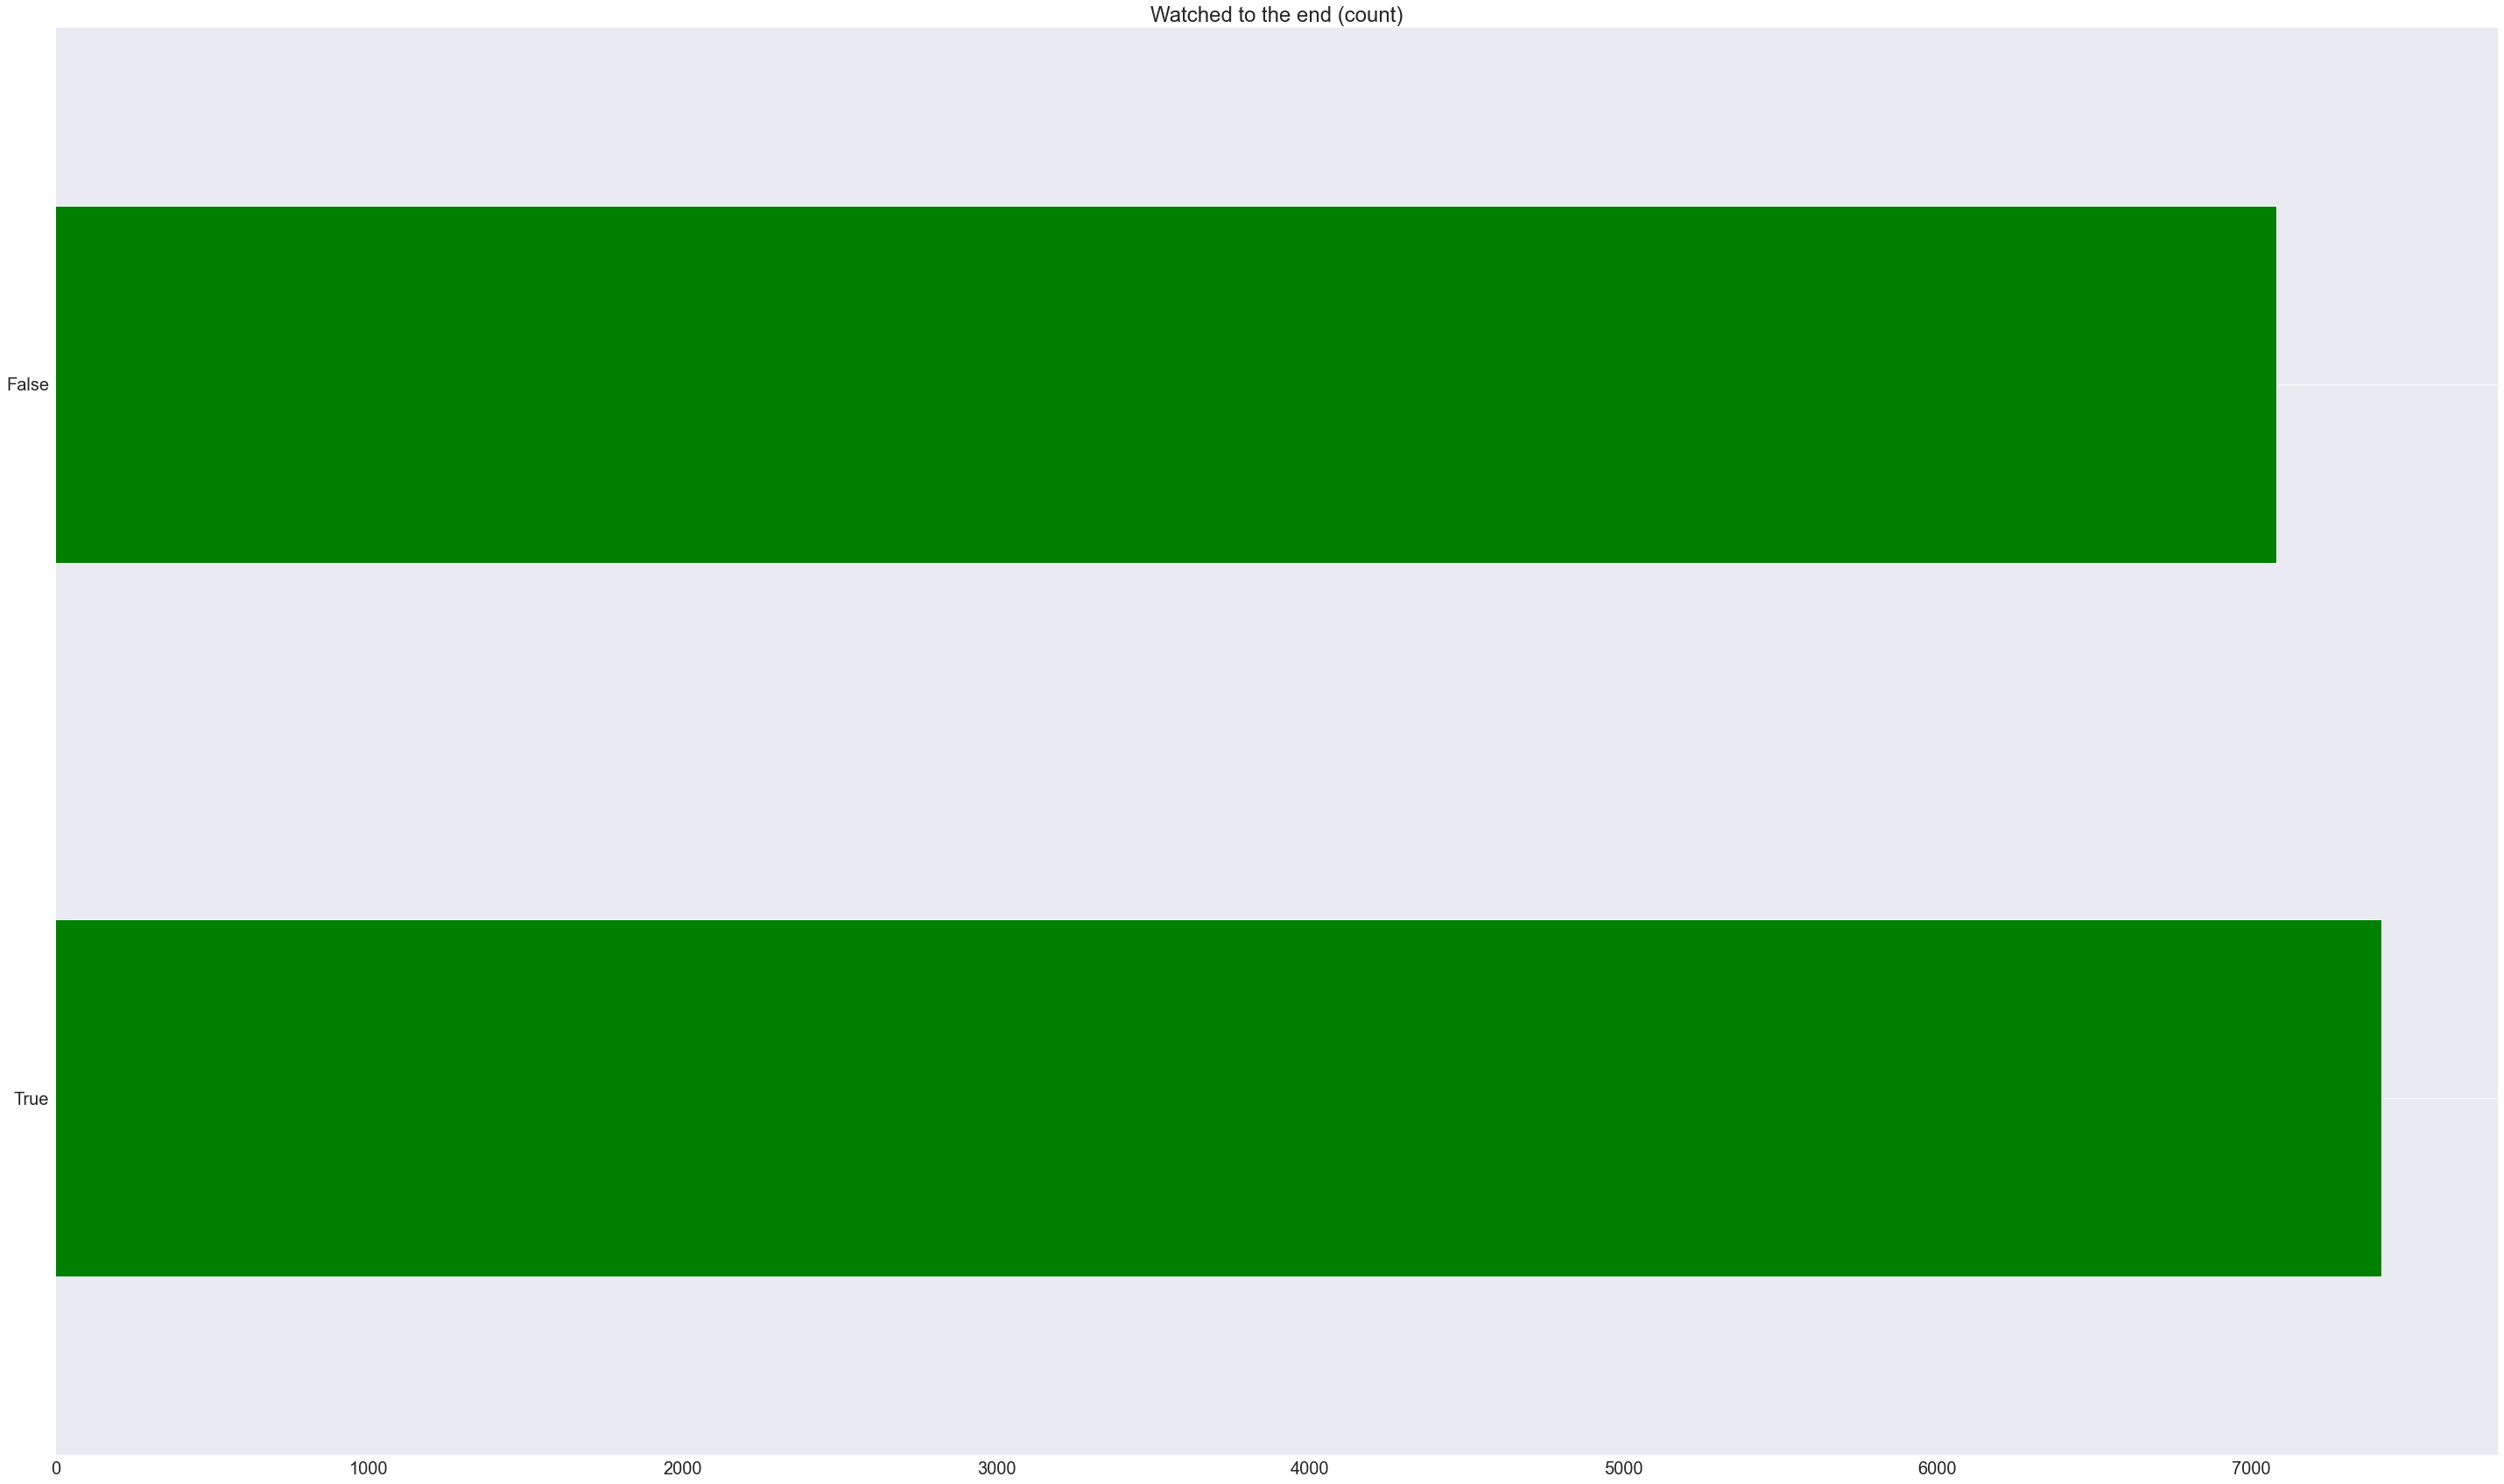

In [79]:
context_set["watched_to_the_end"].value_counts().plot(kind="barh", color="green", title="Watched to the end (count)",
                                                      figsize=(50, 30)).grid(axis='x')
plt.show()

**Preprocessing**
Scaling:

In [80]:
ratings_set = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5, 1)).fit_transform(ratings_set.values),
                           columns=ratings_set.columns, index=ratings_set.index)
ratings_set

art_id,0,1,2,3,4,5,6,7,8,9,...,96004,96005,96006,96007,96008,96009,96010,96011,96012,96013
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Partitioning:

In [81]:
split = int(0.8 * ratings_set.shape[1])
split

76811

Train:

In [82]:
train_set = ratings_set.loc[:, :split - 1]

print("non-null data:", train_set[train_set > 0].count().sum())

train_set

non-null data: 11659


art_id,0,1,2,3,4,5,6,7,8,9,...,76801,76802,76803,76804,76805,76806,76807,76808,76809,76810
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Test:

In [83]:
test_set = ratings_set.loc[:, split:]

print("non-null data:", test_set[test_set > 0].count().sum())

test_set

non-null data: 2837


art_id,76811,76812,76813,76814,76815,76816,76817,76818,76819,76820,...,96004,96005,96006,96007,96008,96009,96010,96011,96012,96013
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Baseline (Content-Based)**
Select a user:

In [84]:
i = 1

train = train_set.iloc[i].to_frame(name="y")
test = test_set.iloc[i].to_frame(name="y")

print("train:", len(train[~train["y"].isna()]), "| test:", len(test[~test["y"].isna()]))

test.head()

train: 16 | test: 3


,y
art_id,
76811,NaN
76812,NaN
76813,NaN
76814,NaN
76815,NaN


Add all arts in test as empty:

In [85]:
tmp = test.copy()
tmp["y"] = np.nan

train = train.append(tmp)

train.tail()

,y
art_id,
96009,NaN
96010,NaN
96011,NaN
96012,NaN
96013,NaN


Create Model:

In [86]:
usr = train[["y"]].fillna(0).values.T

prd = wiki_art_set.drop(["image_path", "genre"], axis=1).values

print("Users", usr.shape, " x  Arts", prd.shape)

Users (1, 96014)  x  Arts (96014, 15)


In [87]:
## usr_ft(users,features) = usr(users,arts) x prd(arts,features)
usr_ft = np.dot(usr, prd)
## normalize
weights = usr_ft / usr_ft.sum()
## predicted rating(users,arts) = weights(users,features) x prd.T(features,arts)
prediction = np.dot(weights, prd.T)

test = test.merge(pd.DataFrame(prediction[0], columns=["yhat"]), how="left", left_index=True,
                  right_index=True).reset_index()

test = test[~test["y"].isna()]

test

,art_id,y,yhat
8044,84855,0.5,84852.434755
13304,90115,0.5,90112.275740
16031,92842,0.5,92839.193300


Evaluate:

In [88]:
def mean_reciprocal_rank(y_test, predicted):
    score = []
    for product in y_test:
        mrr = 1 / (list(predicted).index(product) + 1) if product in predicted else 0
        score.append(mrr)
    return np.mean(score)


print("--- user", i, "---")

top = 5
y_test = test.sort_values("y", ascending=False)["art_id"].values[:top]
print("y_test:", y_test)

predicted = test.sort_values("yhat", ascending=False)["art_id"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "(" + str(round(true_positive / top * 100, 1)) + "%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test, predicted) * 100, 1)) + "%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted), 2))

--- user 1 ---
y_test: [84855 90115 92842]
predicted: [92842 90115 84855]
true positive: 3 (60.0%)
accuracy: 33.3%
mrr: 0.61


In [89]:
test.merge(
    wiki_art_set[["image_path", "art_id", "genre"]], left_on="art_id", right_index=True
).sort_values("yhat", ascending=False)

,art_id,art_id_x,y,yhat,image_path,art_id_y,genre
16031,92842,92842,0.5,92839.193300,/kaggle/input/wikiart-gangogh-creating-art-gan...,92842,landscape
13304,90115,90115,0.5,90112.275740,/kaggle/input/wikiart-gangogh-creating-art-gan...,90115,landscape
8044,84855,84855,0.5,84852.434755,/kaggle/input/wikiart-gangogh-creating-art-gan...,84855,landscape


**Model implementation & testing:**

In [90]:
train = train_set.stack(dropna=True).reset_index().rename(columns={0: "y"})
train.head()

,user_id,art_id,y
0,1,1395,0.5
1,1,8807,1.0
2,1,16365,0.5
3,1,21474,0.5
4,1,32920,0.5


In [91]:
test = test_set.stack(dropna=True).reset_index().rename(columns={0: "y"})
test.head()

,user_id,art_id,y
0,1,80311,0.5
1,1,86062,0.5
2,1,89643,0.5
3,1,90095,0.5
4,1,92178,0.5


Model:

In [92]:
embeddings_size = 50
usr, prd = ratings_set.shape[0], ratings_set.shape[1]

# Users (,1,embedding_size) and Reshape (,embedding_size)
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xusers_emb = layers.Embedding(name="xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
xusers = layers.Reshape(name='xusers', target_shape=(embeddings_size,))(xusers_emb)

# Products (,1,embedding_size) and Reshape (,embedding_size)
xarts_in = layers.Input(name="xarts_in", shape=(1,))
xarts_emb = layers.Embedding(name="xarts_emb", input_dim=prd, output_dim=embeddings_size)(xarts_in)
xarts = layers.Reshape(name='xarts', target_shape=(embeddings_size,))(xarts_emb)

# Product (,1) values[-1,1]
xx = layers.Dot(name='xx', normalize=True, axes=1)([xusers, xarts])

# Predict ratings (,1)
y_out = layers.Dense(name="y_out", units=1, activation='linear')(xx)

# Compile
model = models.Model(inputs=[xusers_in, xarts_in], outputs=y_out, name="CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xarts_in (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 xusers_emb (Embedding)         (None, 1, 50)        50000       ['xusers_in[0][0]']              
                                                                                                  
 xarts_emb (Embedding)          (None, 1, 50)        4800700     ['xarts_in[0][0]']               
                                                                             

In [93]:
# utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [95]:
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15, 3))

    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()

    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_' + metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

training = model.fit(x=[train["user_id"], train["art_id"]], y=train["y"],
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

InvalidArgumentError: Graph execution error:

Detected at node 'CollaborativeFiltering/xusers_emb/embedding_lookup' defined at (most recent call last):
    File "C:\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\kulag\AppData\Local\Temp\ipykernel_4064\4209701058.py", line 28, in <cell line: 28>
      training = model.fit(x=[train["user_id"], train["art_id"]], y=train["y"],
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\keras\engine\training.py", line 1445, in fit
      val_logs = self.evaluate(
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\keras\engine\training.py", line 1756, in evaluate
      tmp_logs = self.test_function(iterator)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\keras\engine\training.py", line 1557, in test_function
      return step_function(self, iterator)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\keras\engine\training.py", line 1546, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\keras\engine\training.py", line 1535, in run_step
      outputs = model.test_step(data)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\keras\engine\training.py", line 1499, in test_step
      y_pred = self(x, training=False)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kulag\DataspellProjects\Arts\venv\lib\site-packages\keras\layers\core\embedding.py", line 199, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'CollaborativeFiltering/xusers_emb/embedding_lookup'
indices[28,0] = 1000 is not in [0, 1000)
	 [[{{node CollaborativeFiltering/xusers_emb/embedding_lookup}}]] [Op:__inference_test_function_1685]